# Mô hình logistic survival
Bs Vương Kiến Thanh

Bài này sẽ fit mô hình như đã nói ở bài trước. Nhưng sẽ xem `qsmk` là index.

$$\begin{aligned}
\text{logit hazard} &= \theta_{0,k} + \theta_1[qsmk] + \theta_2[qsmk] \times k + \theta_3[qsmk]\times k^2\\
\theta_{0,k} &= \theta_0 + \theta_4 \times k + \theta_5 \times k^2\\
\end{aligned}$$

Sau khi có được hazard tại từng thời điểm, survival có thể được tính bằng:
$$ Pr[D_{k+1}=0 |A=a] = \Pi_{m=1}^k 1-\text{hazard}_m$$

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from numpyro import sample, deterministic
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import arviz as az
import jax.numpy as jnp
from jax.random import PRNGKey
from jax.scipy.special import expit
from jax import vmap
from sklearn.preprocessing import StandardScaler
az.style.use("fivethirtyeight")

### Dataset và tính thời gian đến sự kiện theo tháng

In [53]:
# col_info = pd.read_excel(
#     r'https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/2012/10/NHEFS_Codebook.xls')
usecols=['qsmk','death','yrdth','modth']
df = pd.read_csv(
    r'https://cdn1.sph.harvard.edu/wp-content/uploads/sites/1268/1268/20/nhefs.csv',
    usecols=usecols,
    dtype={'qsmk':int})
# get time to death in months
df['d']=np.where(df['death']==1, (df['yrdth']-83)*12 + df['modth'], np.nan)

### Hàm tính survival từ hazard và chuyển data thành định dạng person-time
Định dạng person-time để có thể feed vào mô hình. Dòng đầu tiên là thông tin của người 1 tại $k=0$, dòng thứ hai là thông tin của người 1 tại $k=1$, và tiếp tục đến cuối kỳ theo dõi của người đó. Tiếp theo đến người 2 và cứ thế thêm vào.

Việc scale lại `time` sẽ tối ưu MCMC hơn.

In [6]:
def survival_curve(hazard):
    survival = [1 - hazard[0]]
    for i in range(1, len(hazard)):
        survival.append((1 - hazard[i]) * survival[i - 1])
    return jnp.array(survival)

def person_time_format(DF):
    qsmk = []
    time = []
    death = []
    def add(row):
        if pd.isna(row['d']):
            qsmk.extend([row['qsmk']] *120)
            time.extend(range(120))
            death.extend([0]*120)
        else:
            t = int(row['d'])
            qsmk.extend([row['qsmk']]*t)
            time.extend(range(t))
            death.extend([0]*(t-1) + [1])
    DF.apply(add, axis=1)
    return pd.DataFrame({'qsmk':qsmk, 'time':time, 'death':death}, dtype=int)
    
def scale_time(DF):
    scaler = StandardScaler()
    DF['std_time'] = scaler.fit_transform(DF[['time']])
    return DF,scaler

df2 = person_time_format(df)
df2, scaler = scale_time(df2)
df2

,qsmk,time,death,std_time
0,0,0,0,-1.653591
1,0,1,0,-1.624671
2,0,2,0,-1.595751
3,0,3,0,-1.566831
4,0,4,0,-1.537911
...,...,...,...,...
176759,1,115,0,1.672209
176760,1,116,0,1.701129
176761,1,117,0,1.730049
176762,1,118,0,1.758969


### Mô hình logistic survival
Các thông số divergence, r^, plot_trace đều rất Ok.

In [30]:
def model(qsmk,time, death=None, cal=False):
    theta0 = sample('theta0', dist.Normal(0,1))
    theta1 = sample('theta1', dist.Normal(0,1))
    theta2 = sample('theta2', dist.Normal(0,1))
    theta3 = sample('theta3', dist.Normal(0,1).expand([2]))
    theta4 = sample('theta4', dist.Normal(0,1).expand([2]))
    theta5 = sample('theta5', dist.Normal(0,1).expand([2]))
    logit = theta0 + theta1 * time + theta2 * (time**2) +\
        theta3[qsmk] + theta4[qsmk] * time + theta5[qsmk] * (time**2)
    if cal:
        hazard = deterministic('hazard', expit(logit))
    sample('death', dist.Binomial(logits=logit), obs=death)
    
data = {
    'qsmk': df2.qsmk.values,
    'time': df2.std_time.values,
    'death': df2.death.values
}

mcmc = MCMC(NUTS(model), 500,2000,4,chain_method='sequential')
mcmc.run(PRNGKey(0), **data)

sample: 100%|██████████| 2500/2500 [20:04<00:00,  2.08it/s, 15 steps of size 5.14e-02. acc. prob=0.94]  


In [31]:
mcmc.print_summary()


                mean       std    median      5.0%     95.0%     n_eff     r_hat
    theta0     -4.02      0.58     -4.02     -4.97     -3.05   3102.33      1.00
    theta1      0.06      0.57      0.06     -0.85      1.01   2905.64      1.00
    theta2     -0.19      0.58     -0.19     -1.15      0.75   3398.01      1.00
 theta3[0]     -2.25      0.58     -2.26     -3.25     -1.33   3095.06      1.00
 theta3[1]     -1.74      0.58     -1.74     -2.67     -0.76   3175.73      1.00
 theta4[0]      0.12      0.58      0.13     -0.80      1.07   2914.58      1.00
 theta4[1]     -0.10      0.58     -0.10     -1.02      0.86   2911.89      1.00
 theta5[0]      0.02      0.58      0.03     -0.90      1.01   3383.34      1.00
 theta5[1]     -0.19      0.58     -0.19     -1.16      0.75   3480.45      1.00

Number of divergences: 0


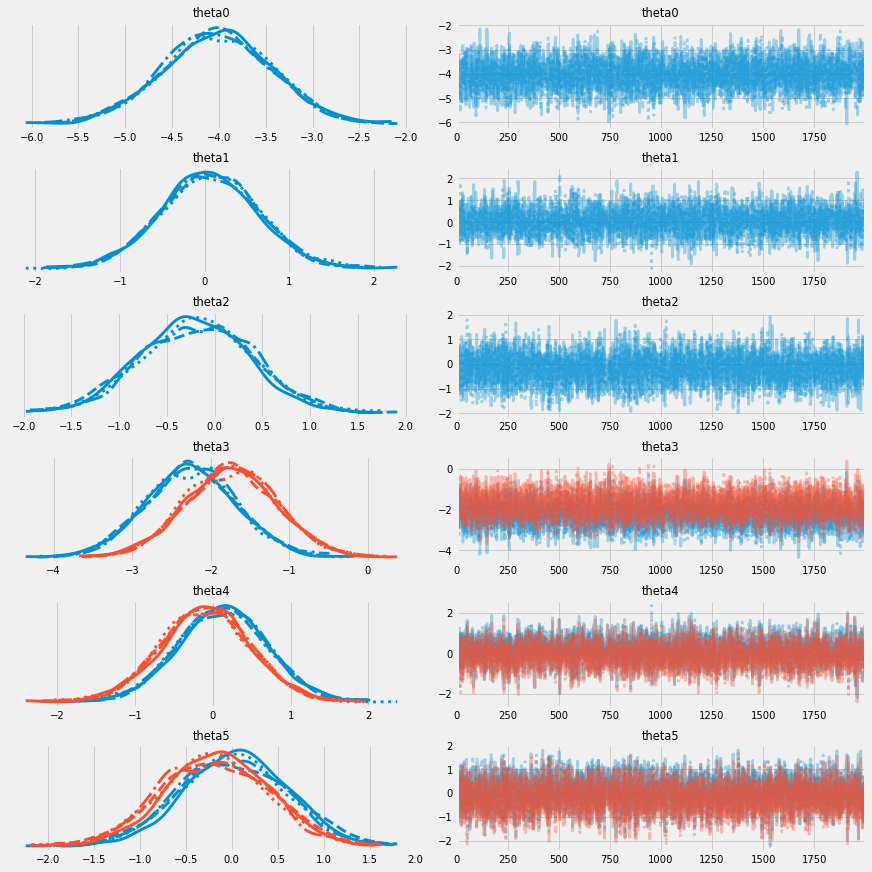

In [32]:
az.plot_trace(mcmc);

### Phân tích posterior
Nhìn vào các phân phối của parameter trong plot_trace, chúng ta thấy rằng `theta1`, `theta2`, `theta4[0,1]`, `theta5[0,1]` có phân phối chứa `0`. Chúng là những parameter không có ý nghĩa. Nếu chúng ta vẫn chọn mô hình linear này thì có thể bỏ qua chúng.

### Để kiểm định giả thuyết thời gian sống còn của 2 nhóm `qsmk` có khác nhau hay không
ta có thể tính survival probability ở từng thời điểm, có thể visualize và tính p-value như sau:


In [60]:
def get_hazard(mcmc, qsmk):
    posterior = mcmc.get_samples()
    return Predictive(mcmc.sampler.model, posterior, return_sites=['hazard'])(
        PRNGKey(1), qsmk=qsmk,
        time=scaler.transform(np.arange(120).reshape(-1,1)).flatten(),
        cal=True
    )['hazard']

hazard0 = get_hazard(mcmc, 0)
hazard1 = get_hazard(mcmc, 1)
survival0 = vmap(survival_curve)(hazard0)
survival1 = vmap(survival_curve)(hazard1)

In [66]:
hazard0.shape, survival0.shape

((8000, 120), (8000, 120))

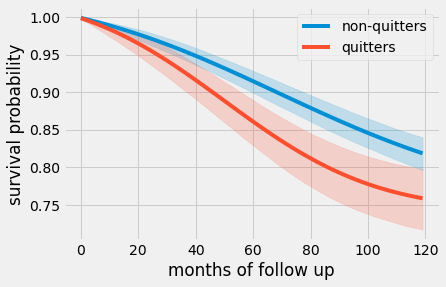

In [69]:
plt.plot(range(120), survival0.mean(0), label='non-quitters')
plt.plot(range(120), survival1.mean(0), label='quitters')
plt.fill_between(
    range(120),
    *jnp.quantile(survival0, q=jnp.array([0.025,0.975]),axis=0),
    color='C0', alpha=0.2)
plt.fill_between(
    range(120),
    *jnp.quantile(survival1, q=jnp.array([0.025,0.975]),axis=0),
    color='C1', alpha=0.2)
plt.legend();
plt.ylabel('survival probability')
plt.xlabel('months of follow up');

#### Đường cong survival này là phiên bản mượt hơn của đường Kaplan Meier.

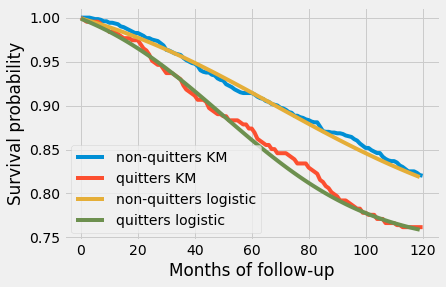

In [72]:
def hazard(DF):
    survive_nan = DF['d'].isna().sum()
    return list(map(
        lambda i: (DF['d']==i).sum() / (survive_nan +(DF['d']>(i-1)).sum()),
        range(121)
    ))
plt.plot(range(121), survival_curve(hazard(df[df['qsmk']==0])), label='non-quitters KM')
plt.plot(range(121), survival_curve(hazard(df[df['qsmk']==1])), label='quitters KM')
plt.plot(range(120), survival0.mean(0), label='non-quitters logistic')
plt.plot(range(120), survival1.mean(0), label='quitters logistic')
plt.ylabel('Survival probability')
plt.xlabel('Months of follow-up')
plt.legend();

Để biện luận chính xác hai giả thuyết, ta cần thêm phân phối của hiệu giữa hai xác suất sống còn, hay còn gọi là contrast.

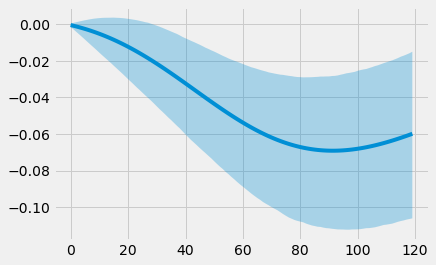

In [70]:
contrast = survival1 - survival0
plt.plot(range(120), contrast.mean(0))
plt.fill_between(
    range(120),
    *jnp.quantile(contrast,q=jnp.array([0.025,0.975]),axis=0),
    alpha=0.3);

Trên plot, ta thấy ở 25-30 tháng đầu tiên, không có sự khác biệt rõ ràng giữa 2 nhóm `qsmk` (chứa số 0). Từ  tháng 30 trở đi, phân phối (tin cậy 95%) tách khỏi và xa dần số 0. 

Ta có tính p-value là phần diện tích >=0  bằng cách đếm frequency:  
Xác suất để hiệu giữa nhóm `qsmk=1` và `qsmk=0` >= 0 là:

In [73]:
contrast[contrast >0].shape[0] / (contrast.shape[0]*contrast.shape[1])

0.028167708333333333